In [92]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import fontManager

#Colab 進行matplotlib繪圖時顯示繁體中文
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


--2023-08-29 11:54:45--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.197.138, 74.125.197.102, 74.125.197.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ufvun6amir31vm78jfr2c7p9f6eeg6b9/1693310025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=5f711193-c212-4b2d-91e7-c114308e08eb [following]
--2023-08-29 11:54:48--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ufvun6amir31vm78jfr2c7p9f6eeg6b9/1693310025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=5f711193-c212-4b2d-91e7-c114308e08eb
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [93]:
API_KEY = 'Input your key here'

In [94]:
channel_ids = ['UCvTe3Z7TZsjGzUERx4Ce6zA',
        # more channels here
        ]
#To get the channel id, you can use this link: https://commentpicker.com/youtube-channel-id.php

In [95]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
  api_service_name, api_version, developerKey = API_KEY)

In [96]:
def get_channel_stats(youtube, channel_ids):

  all_data = []

  request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
  )
  response = request.execute()

  # loop through items
  for item in response['items']:
      data = {'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
      }

      all_data.append(data)

  return pd.DataFrame(all_data)

In [97]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [98]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,攝徒日記Fun TV,782000,407355671,1386,UUvTe3Z7TZsjGzUERx4Ce6zA


In [99]:
playlistId="UUvTe3Z7TZsjGzUERx4Ce6zA"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    #因為maxResults只能最多提取50個Result，因此需要用while loop一直搜尋到最後一頁，獲取全部video id
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [100]:
video_ids = get_video_ids(youtube, playlistId)
len(video_ids)

1314

In [101]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    #因為API限制，一次最多只可以提取50個結果，所以for loop需要每50跳
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [102]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,7CgCIP7kvwI,攝徒日記Fun TV,反駁小粉紅必看！中國集體魔征⋯電話騷擾日本店家⋯去日校扔石頭⋯老闆嗆：本店食材來自福島廢水,反駁小粉紅必看！中國集體魔征⋯電話騷擾日本店家⋯去日校扔石頭⋯老闆嗆：本店食材來自福島廢水\...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 八炯 小粉紅, 攝徒日記 小粉紅]",2023-08-29T11:54:39Z,1,0,None,0,PT13M58S,hd,true
1,U95BGyC_3XI,攝徒日記Fun TV,中國鹽荒子孫的逆襲！,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖]",2023-08-29T06:03:43Z,10277,1073,None,114,PT28S,hd,false
2,V4Ep9EKdECc,攝徒日記Fun TV,小粉紅嗆日本排廢水⋯大哭#shorts,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖]",2023-08-28T15:03:55Z,8493,540,None,204,PT48S,hd,false
3,kva5IDKUWxI,攝徒日記Fun TV,打臉中國科普網紅！台灣人快喝日本廢水⋯小粉紅跳水反日⋯鹽荒子孫一天吃三公斤,打臉中國科普網紅！核汙水跟核廢水區別在哪？要相信世界原子專家們的話，還是一個三年都在亂搞特色...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 關鍵時刻, 八炯 小粉红, ...",2023-08-28T12:46:23Z,265742,13830,None,3682,PT13M15S,hd,false
4,kGWuSgHe4Yo,攝徒日記Fun TV,小粉紅尷尬秀！中國八部恥度特輯⋯集體大鬧日本⋯台灣人心臟不夠強別看⋯,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 關鍵時刻, 八炯 小粉红, ...",2023-08-27T12:16:34Z,308761,12937,None,3558,PT13M14S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,CdjbKWoLQT0,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜新城村5大秘境｜立霧溪出海口比偶像劇場景還美,攝徒日記-89去旅行\n\n曼波魚的故鄉，新城村的獨家推薦\n往往大家所熟悉的新城只會想到七...,"[花蓮, 景點, 新城, 七星潭, 檸檬汁, 天主堂, 旅遊, vlog, 秘境, taiw...",2018-11-12T11:00:02Z,34332,338,None,28,PT4M53S,hd,false
1310,b3esFwRBLtY,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜太魯閣白楊步道水濂洞 [Taiwan Travel ] Huali...,在太魯閣天祥山區不遠處的白楊步道水濂洞\n封閉1年多後，在10月28日重新開放\n夏天來到山...,"[太魯閣, 花蓮, 水濂洞, 白楊步道, 旅遊, 旅行, 秘境, hualien, taiw...",2018-11-06T12:00:05Z,10513,179,None,25,PT4M51S,hd,true
1311,Fdh52HvQBOo,攝徒日記Fun TV,花蓮活動｜2018太魯閣音樂祭｜多元民族共融,攝徒日記-89去旅行的主持人\n本身除了是道地的花蓮人之外\n更是太魯閣族的一員\n這次介紹...,"[太魯閣, 音樂祭, 花蓮, 台灣, VLOG, 旅遊, 旅行, 景點, 花蓮景點, 新城,...",2018-10-30T11:30:00Z,3225,111,None,24,PT5M1S,hd,false
1312,Wi7NAlypr0c,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜屬於花蓮文青的博愛特區｜即將熄燈,攝徒日記-89去旅行\n\n趕在10/31結束營業前，來拍攝博愛特區\n紀錄他最後的美貌，給...,"[花蓮, 文青, 博愛特區, vlog, 旅遊, 景點, 花蓮景點, taiwan, hua...",2018-10-23T11:28:16Z,2939,88,None,10,PT1M20S,hd,false


## Data pre-processing

In [103]:
video_df.isnull().any() #check for NULL values

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [104]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [105]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [106]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [107]:
pip install isodate

In [108]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [109]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,838.0,PT13M58S
1,28.0,PT28S
2,48.0,PT48S
3,795.0,PT13M15S
4,794.0,PT13M14S
...,...,...
1309,293.0,PT4M53S
1310,291.0,PT4M51S
1311,301.0,PT5M1S
1312,80.0,PT1M20S


In [110]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [111]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,7CgCIP7kvwI,攝徒日記Fun TV,反駁小粉紅必看！中國集體魔征⋯電話騷擾日本店家⋯去日校扔石頭⋯老闆嗆：本店食材來自福島廢水,反駁小粉紅必看！中國集體魔征⋯電話騷擾日本店家⋯去日校扔石頭⋯老闆嗆：本店食材來自福島廢水\...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 八炯 小粉紅, 攝徒日記 小粉紅]",2023-08-29 11:54:39+00:00,1.0,0.0,NaN,0.0,PT13M58S,hd,true,Tuesday,838.0,9
1,U95BGyC_3XI,攝徒日記Fun TV,中國鹽荒子孫的逆襲！,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖]",2023-08-29 06:03:43+00:00,10277.0,1073.0,NaN,114.0,PT28S,hd,false,Tuesday,28.0,7
2,V4Ep9EKdECc,攝徒日記Fun TV,小粉紅嗆日本排廢水⋯大哭#shorts,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖]",2023-08-28 15:03:55+00:00,8493.0,540.0,NaN,204.0,PT48S,hd,false,Monday,48.0,7
3,kva5IDKUWxI,攝徒日記Fun TV,打臉中國科普網紅！台灣人快喝日本廢水⋯小粉紅跳水反日⋯鹽荒子孫一天吃三公斤,打臉中國科普網紅！核汙水跟核廢水區別在哪？要相信世界原子專家們的話，還是一個三年都在亂搞特色...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 關鍵時刻, 八炯 小粉红, ...",2023-08-28 12:46:23+00:00,265742.0,13830.0,NaN,3682.0,PT13M15S,hd,false,Monday,795.0,18
4,kGWuSgHe4Yo,攝徒日記Fun TV,小粉紅尷尬秀！中國八部恥度特輯⋯集體大鬧日本⋯台灣人心臟不夠強別看⋯,📺️頻道會員：https://www.youtube.com/channel/UCvTe3Z...,"[中國, 中共, 攝徒日記, 八炯, 小粉紅, 台灣, 設圖, 關鍵時刻, 八炯 小粉红, ...",2023-08-27 12:16:34+00:00,308761.0,12937.0,NaN,3558.0,PT13M14S,hd,true,Sunday,794.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,CdjbKWoLQT0,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜新城村5大秘境｜立霧溪出海口比偶像劇場景還美,攝徒日記-89去旅行\n\n曼波魚的故鄉，新城村的獨家推薦\n往往大家所熟悉的新城只會想到七...,"[花蓮, 景點, 新城, 七星潭, 檸檬汁, 天主堂, 旅遊, vlog, 秘境, taiw...",2018-11-12 11:00:02+00:00,34332.0,338.0,NaN,28.0,PT4M53S,hd,false,Monday,293.0,13
1310,b3esFwRBLtY,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜太魯閣白楊步道水濂洞 [Taiwan Travel ] Huali...,在太魯閣天祥山區不遠處的白楊步道水濂洞\n封閉1年多後，在10月28日重新開放\n夏天來到山...,"[太魯閣, 花蓮, 水濂洞, 白楊步道, 旅遊, 旅行, 秘境, hualien, taiw...",2018-11-06 12:00:05+00:00,10513.0,179.0,NaN,25.0,PT4M51S,hd,true,Tuesday,291.0,15
1311,Fdh52HvQBOo,攝徒日記Fun TV,花蓮活動｜2018太魯閣音樂祭｜多元民族共融,攝徒日記-89去旅行的主持人\n本身除了是道地的花蓮人之外\n更是太魯閣族的一員\n這次介紹...,"[太魯閣, 音樂祭, 花蓮, 台灣, VLOG, 旅遊, 旅行, 景點, 花蓮景點, 新城,...",2018-10-30 11:30:00+00:00,3225.0,111.0,NaN,24.0,PT5M1S,hd,false,Tuesday,301.0,13
1312,Wi7NAlypr0c,攝徒日記Fun TV,【花蓮旅遊攻略】花蓮景點｜屬於花蓮文青的博愛特區｜即將熄燈,攝徒日記-89去旅行\n\n趕在10/31結束營業前，來拍攝博愛特區\n紀錄他最後的美貌，給...,"[花蓮, 文青, 博愛特區, vlog, 旅遊, 景點, 花蓮景點, taiwan, hua...",2018-10-23 11:28:16+00:00,2939.0,88.0,NaN,10.0,PT1M20S,hd,false,Tuesday,80.0,11


## Best performing videos

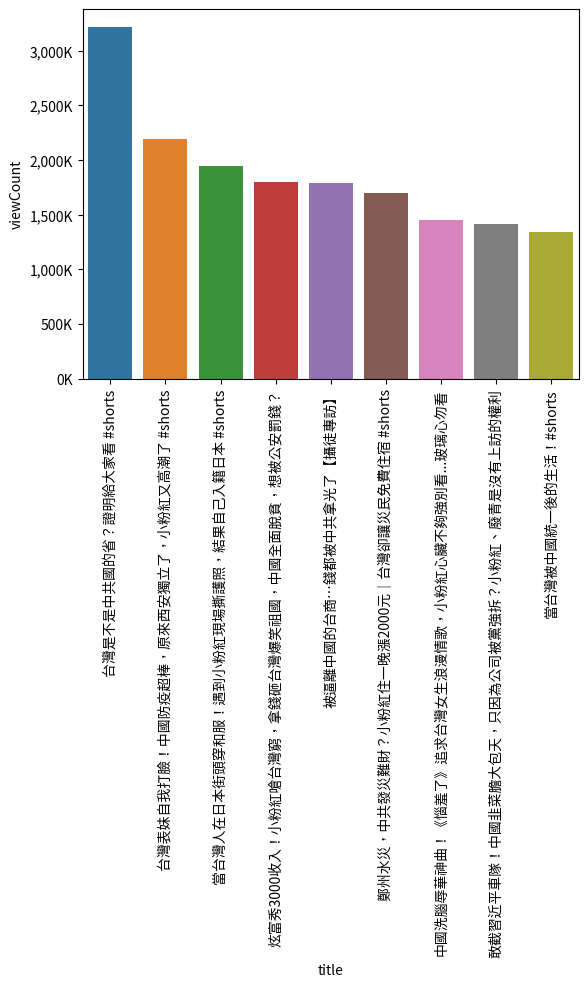

In [112]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

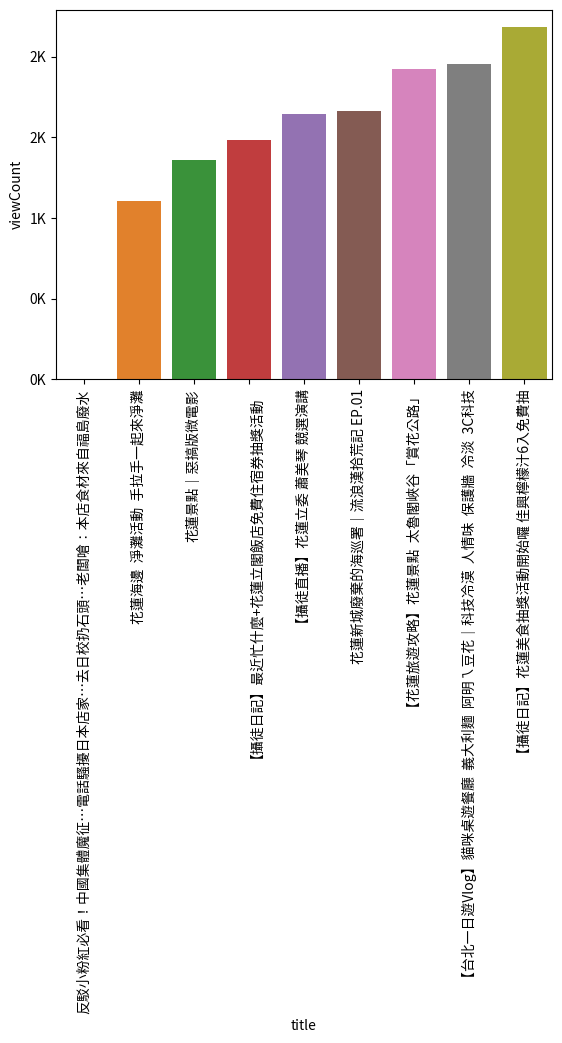

In [113]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

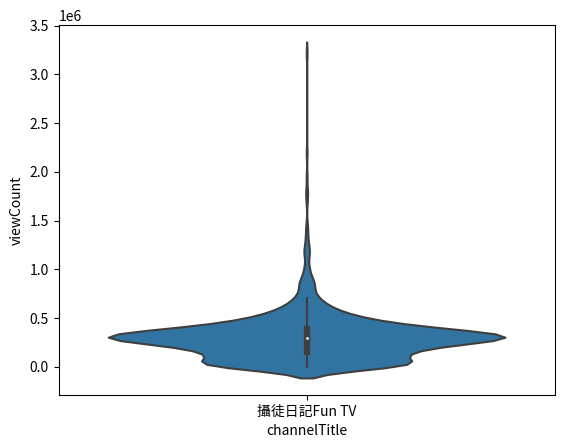

In [114]:
sns.violinplot(x=video_df['channelTitle'],y=video_df['viewCount']) #Violin plot for the channel

## Views vs. likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

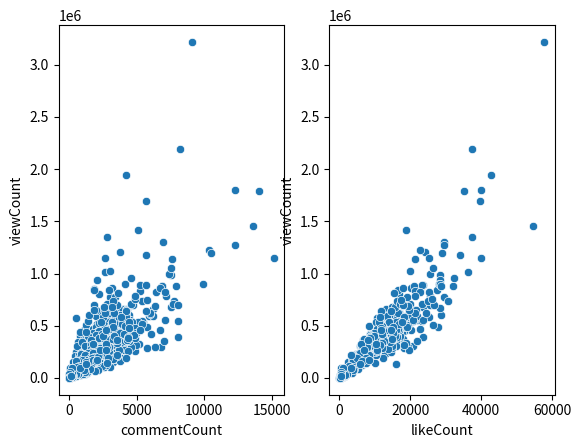

In [115]:
# get the relationship between viewCount and commentCount as well as likeCount
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

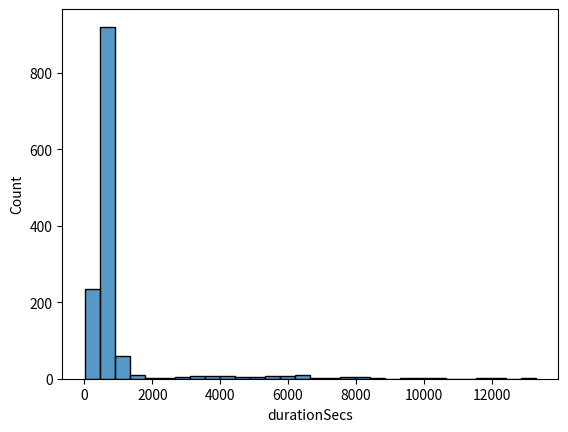

In [116]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

## Wordcloud for video titles in Chinese

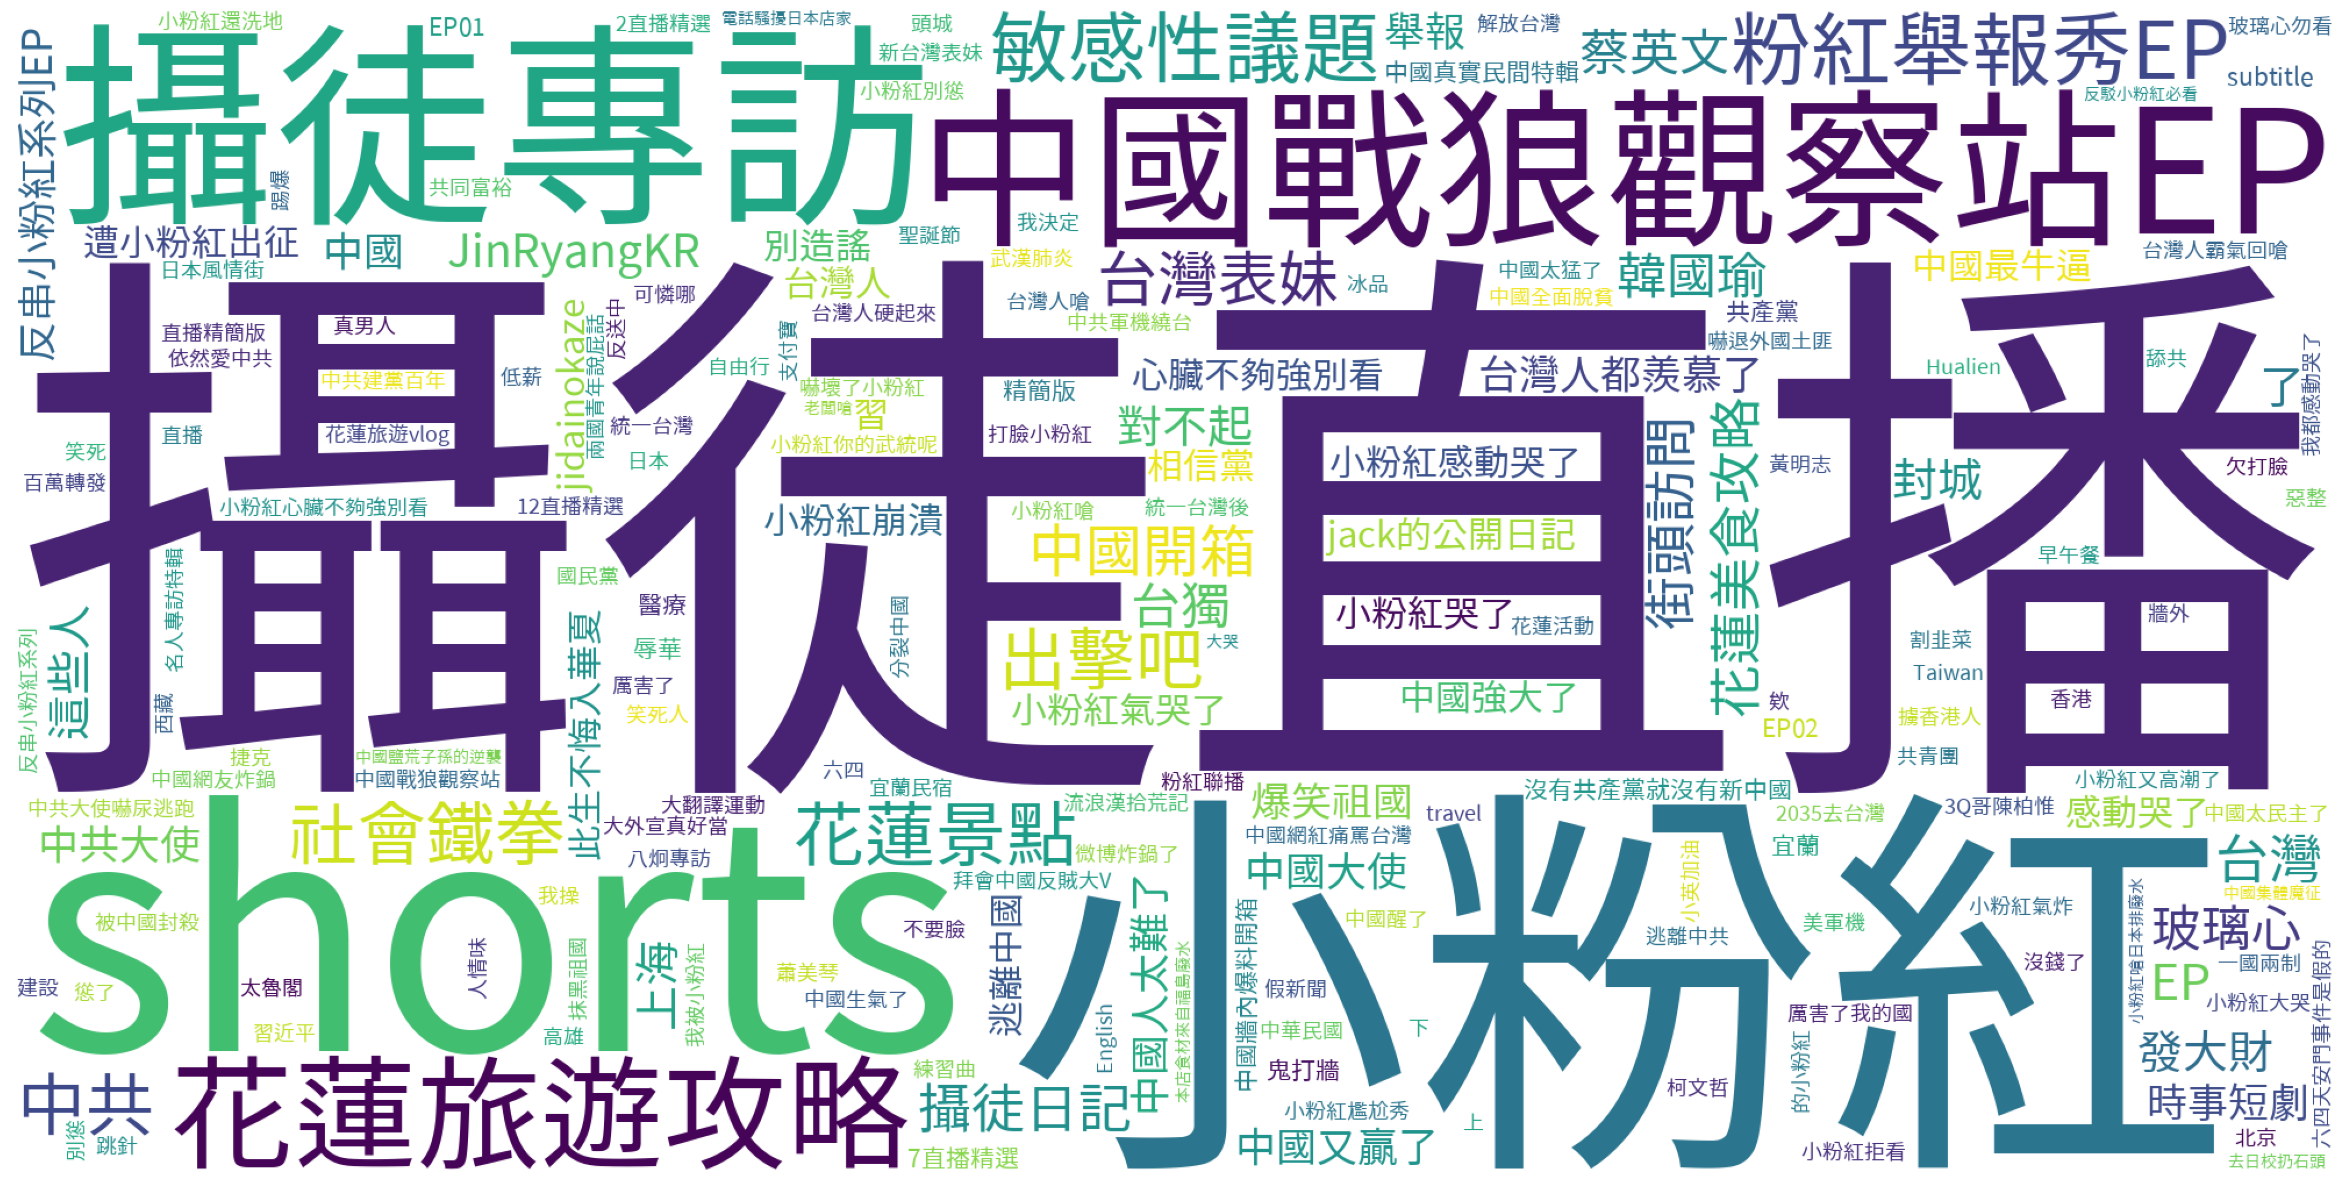

In [117]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False, font_path="TaipeiSansTCBeta-Regular.ttf").generate(all_words_str)
#Because that is Chinese Youtube Channel, we need to change the font_path to support Traditional Chinese
plot_cloud(wordcloud)

## Upload schedule

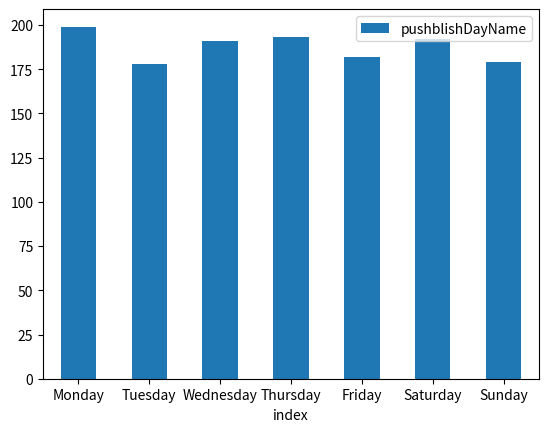

In [118]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)